# Analysis of Building America 2015 Study

In [1]:
import pandas as pd
import numpy as np
import xlwings as xw
# import matplotlib pyplot commands
from matplotlib.pyplot import *
from IPython.display import Image, Markdown
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [16]:
rcParams['figure.figsize']= (10, 6)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

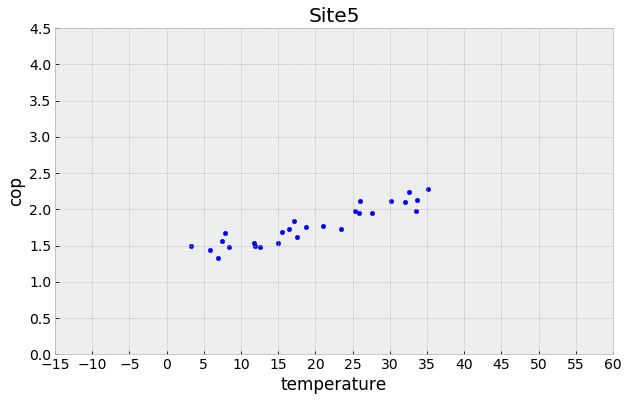

In [23]:
sheet_names = ('Site1', 'Site2', 'Site4', 'Site5', 'Site8', 'Site9', 'Site10')
ix = 3
dfp = pd.read_excel('COP_vs_temp_plots.xlsx', sheet_name=sheet_names[ix])
dfp.plot(x='temperature', y='cop', kind='scatter')
xlim(-15, 60)
ylim(0, 4.5)
title(sheet_names[ix])
gca().set_xticks(np.arange(-15, 61, 5));